# Creating surface forcing

In [1]:
from roms_tools import Grid, SurfaceForcing

As always, the first step is to create our grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, surface forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here we use the following grid.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=2000, size_y=2400, center_lon=-18, center_lat=33, rot=-20
)

Next, we specify the temporal range that we want to make the surface forcing for.

In [3]:
from datetime import datetime

In [4]:
start_time = datetime(2012, 1, 15)
end_time = datetime(2012, 2, 5)

`ROMS-Tools` can create two types of surface forcing:

* physical surface forcing like 10m wind, shortwave radiation, and air temperature at 2m
* biogeochemical (BGC) surface forcing like atmospheric pCO2

These two types need to be created separately as seen in the following sections.

## Physical surface forcing

In this section, we use ERA5 data to create our physical surface forcing. The user is expected to have downloaded the ERA5 data spanning the desired ROMS domain and temporal range from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form). Our downloaded data sits at the following location.

In [5]:
path = "/glade/derecho/scratch/noraloose/Datasets/ERA5/NA/2012/ERA5*"

We now create an instance of the `SurfaceForcing` class with `type = "physics"`.

In [6]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    use_dask=True,  # default is False
)

CPU times: user 8.95 s, sys: 280 ms, total: 9.23 s
Wall time: 30.6 s


The surface forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [7]:
surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

All physical surface forcing fields necessary to run a ROMS simulation are now contained as `dask.arrays` within an `xarray.Dataset`. All data operations are performed lazily, meaning that the surface forcing fields have not been actually computed yet. Full computation will not be triggered until the `.save` method is called.

`ROMS-Tools` has found 505 time stamps within our specified time range. Let's double-check that `ROMS-Tools` has selected the correct times.

In [8]:
surface_forcing.ds.time

<xarray.DataArray 'time' (time: 505)> Size: 4kB
array([4397.      , 4397.041667, 4397.083333, ..., 4417.916667, 4417.958333,
       4418.      ])
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Attributes:
    long_name:  days since 2000-01-01 00:00:00
    units:      days

The `time` variable shows relative time, i.e., days since the model reference date (here set to January 1, 2000 by default). The `abs_time` coordinate shows the absolute time. The ERA5 data provided to `ROMS-Tools` has hourly frequency; this temporal frequency is inherited by `surface_forcing`.

To visualize any of the surface forcing fields, we can use the `.plot` method.

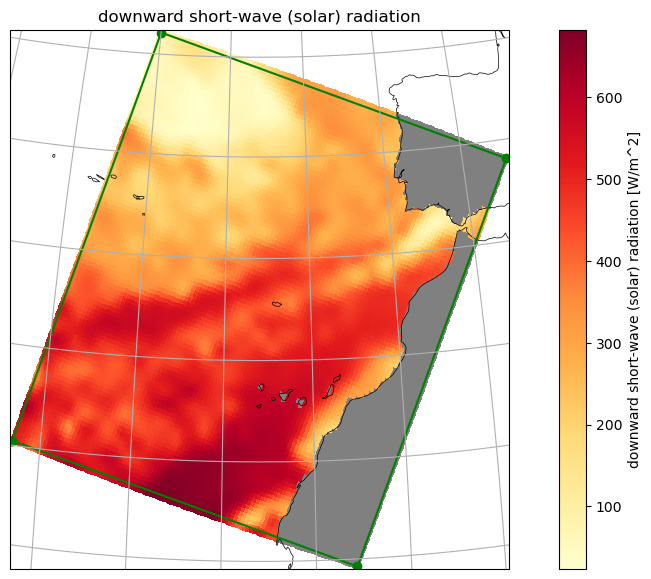

In [9]:
surface_forcing.plot("swrad", time=15)

### Shortwave radiation correction

There is a consensus that global data products such as ERA5 have biases in radiation due to uncertain cloud-radiative feedbacks. `ROMS-Tools` has the ability to correct for these biases. If `correct_radiation = True`, a multiplicative correction factor is applied to the ERA5 shortwave radiation. The correction factors have been pre-computed based on how much the ERA5 climatology differs from the COREv2 climatology.

In [10]:
%%time
corrected_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=True,  # default is False
    use_dask=True,
)

CPU times: user 2.18 s, sys: 116 ms, total: 2.29 s
Wall time: 9.52 s


In [11]:
corrected_surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Here is a plot of the downward short-wave radiation, as before, but now in its corrected version.

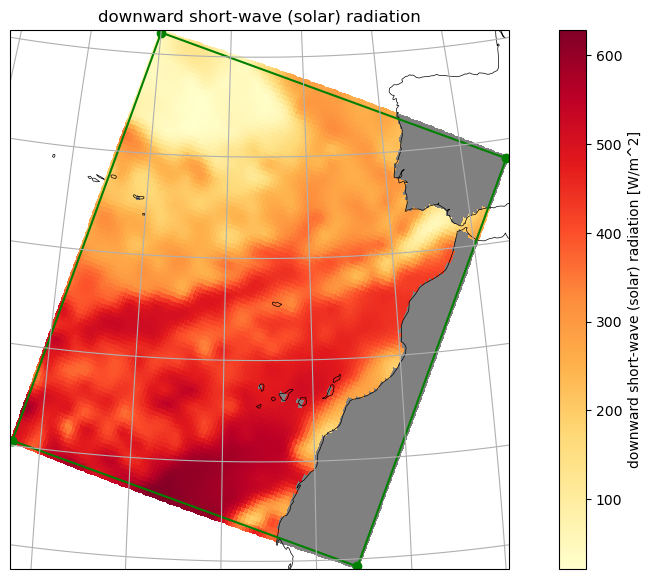

In [12]:
corrected_surface_forcing.plot("swrad", time=15)

To visualize the difference between the corrected and uncorrected short-wave radiation, you can use `xarray`'s plotting method. 

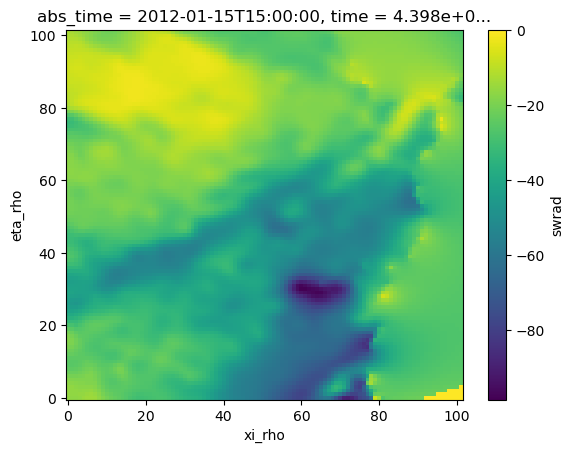

In [13]:
(corrected_surface_forcing.ds - surface_forcing.ds).swrad.isel(time=15).plot()

### Creating surface forcing on a coarsened grid
`ROMS-Tools` has the option to interpolate the surface forcing fields on a grid that is coarsened by a factor of 2. Interpolating to a coarse grid makes sense when the ROMS grid is of much higher resolution than the raw data product (e.g., ERA5).

In [14]:
%%time
coarse_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5", "path": path},
    type="physics",
    correct_radiation=True,
    use_coarse_grid=True,  # default is False
    use_dask=True,
)

CPU times: user 2.08 s, sys: 64.1 ms, total: 2.15 s
Wall time: 8.1 s


In [15]:
coarse_surface_forcing.ds

<xarray.Dataset> Size: 38MB
Dimensions:   (time: 505, eta_rho: 52, xi_rho: 52)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       True
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

The surface forcing fields now live on the coarsened grid. 

<div class="alert alert-info">

Note

The dimension names in `coarse_forcing.ds` are somewhat confusingly called `eta_rho`, `xi_rho` (rather than `eta_coarse`, `xi_coarse`). This is due to a particularity of ROMS - it expects the dimension names `eta_rho`, `xi_rho`. We should change this in the future! 

</div>

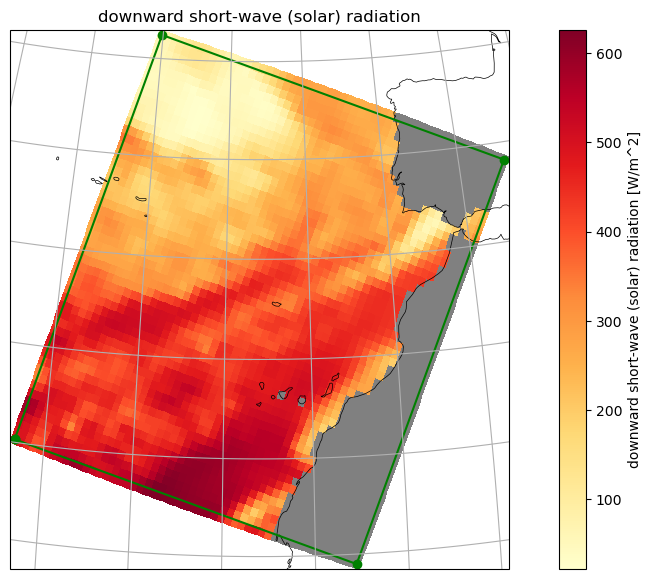

In [16]:
coarse_surface_forcing.plot("swrad", time=15)

## Biogeochemical (BGC) surface forcing
We now create BGC surface forcing. The BGC variables are interpolated from a CESM dataset with monthly frequency, which is located here.

In [17]:
path = "/glade/derecho/scratch/noraloose/Datasets/CESM_REGRIDDED/CESM-surface_lowres_regridded.nc"

In [18]:
%%time

bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "CESM_REGRIDDED", "path": path},
    type="bgc",
    use_dask=True,
)

CPU times: user 259 ms, sys: 135 ms, total: 393 ms
Wall time: 1.06 s


In [19]:
bgc_surface_forcing.ds

<xarray.Dataset> Size: 749kB
Dimensions:       (time: 3, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time      (time) datetime64[ns] 24B 2012-01-01 2012-02-01 2012-03-01
    pco2_time     (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    iron_time     (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    dust_time     (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    nox_time      (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
    nhy_time      (time) float64 24B 4.383e+03 4.414e+03 4.443e+03
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 125kB dask.array<chunksize=(3, 102, 102), meta=np.ndarray>
    pco2_air_alt  (time, eta_rho, xi_rho) float32 125kB dask.array<chunksize=(3, 102, 102), meta=np.ndarray>
    iron          (time, eta_rho, xi_rho) float32 125kB dask.array<chunksize=(3, 102, 102), meta=np.ndarray>
    dust          (time, eta_rho, xi_rho) float32 125kB dask.array<chunksize=(3, 102, 102), meta=np.ndarray>
    nox           (time, eta_rho, xi_rho) float32 125kB dask.array<chunksize=(3, 102, 102), meta=np.ndarray>
    nhy           (time, eta_rho, xi_rho) float32 125kB dask.array<chunksize=(3, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                CESM_REGRIDDED
    correct_radiation:     False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc

Note that the data in `source={"name": "CESM_REGRIDDED", "path": bgc_path}` has monthly frequency. `bgc_surface_forcing.ds` has three time entries because `ROMS-Tools` makes sure to include one time entry at or before the `start_time`, and one time entry at or after the `end_time`. This is essential for proper functioning within ROMS. If the provided data does not meet this requirement, `ROMS-Tools` will issue a warning.

We can plot the BGC surface forcing as we saw above.

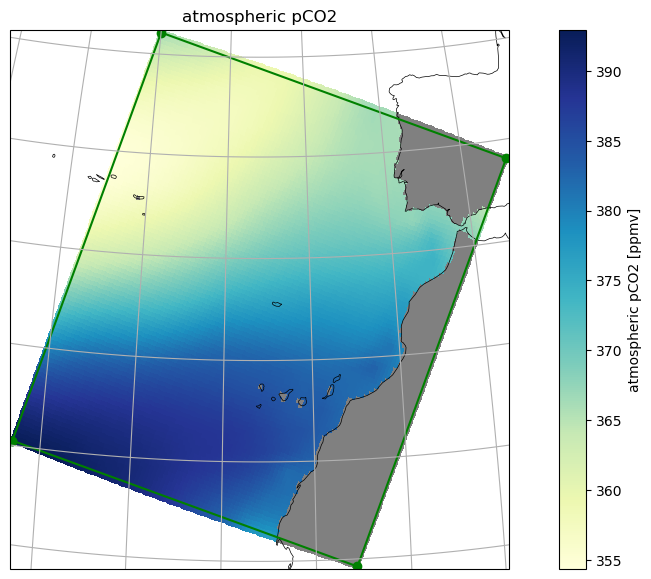

In [20]:
bgc_surface_forcing.plot("pco2_air", time=0)

Similarly as for the physical surface forcing, we can create BGC surface forcing on a coarsened grid by setting `use_coarse_grid = True`. Note, however, that ROMS may not accept coarsened BGC surface forcing.

## Saving as NetCDF or YAML file
Once we have decided which of the surface forcing versions we actually want to use, we can save the dataset as a series of NetCDF files.

We need to specify a prefix for the desired target path.

In [21]:
filepath = "/glade/derecho/scratch/noraloose/forcing/my_surface_forcing"

`ROMS-Tools` will group the surface forcing by year and month and append the year and month information to this path. The files will be named with the format `filepath.YYYYMM.nc` if a full month of data is included (at least one data point per day), or `filepath.YYYYMMDD-DD.nc` otherwise.

Let's save the physical surface forcing with corrected radiation. As a reminder, this dataset has 504 time entries:

In [22]:
corrected_surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

In [23]:
from dask.diagnostics import ProgressBar

In [24]:
with ProgressBar():
    %time corrected_surface_forcing.save(filepath)

Saving the following files:
/glade/derecho/scratch/noraloose/forcing/my_surface_forcing_20120115-31.nc
/glade/derecho/scratch/noraloose/forcing/my_surface_forcing_20120201-05.nc
[########################################] | 100% Completed | 538.65 s
CPU times: user 3min 10s, sys: 6.96 s, total: 3min 17s
Wall time: 9min 10s


We can also export the parameters of our `SurfaceForcing` object to a YAML file.

In [25]:
yaml_filepath = "/glade/derecho/scratch/noraloose/forcing/my_surface_forcing.yaml"

In [26]:
corrected_surface_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [27]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev73+dirty
---
Grid:
  N: 100
  center_lat: 33
  center_lon: -18
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: -20
  size_x: 2000
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5
SurfaceForcing:
  correct_radiation: true
  end_time: '2012-02-05T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  source:
    climatology: false
    name: ERA5
    path: /glade/derecho/scratch/noraloose/Datasets/ERA5/NA/2012/ERA5*
  start_time: '2012-01-15T00:00:00'
  type: physics
  use_coarse_grid: false



## Creating surface forcing from an existing YAML file

In [28]:
%time the_same_corrected_surface_forcing = SurfaceForcing.from_yaml(yaml_filepath, use_dask=True)

CPU times: user 5.21 s, sys: 834 ms, total: 6.05 s
Wall time: 12.5 s


In [29]:
the_same_corrected_surface_forcing.ds

<xarray.Dataset> Size: 147MB
Dimensions:   (time: 505, eta_rho: 102, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-05
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev73+dirty
    start_time:            2012-01-15 00:00:00
    end_time:              2012-02-05 00:00:00
    source:                ERA5
    correct_radiation:     True
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics